# NX-421 Mini Project — Group P, Variant 1 (PCA) with Preprocessing

## Pipeline
1. **Project setup & inputs**
2. **Structural preprocessing (T1)**: skull-strip (mask-based), tissue segmentation, normalization
3. **Functional preprocessing (T2)**: firstfew volumes removal, silce timing?, motion correction, coregistration, spatial smoothing
4. **Design matrix (concatenated)**
5. **First-level GLM**
6. **Example contrast**
6. **PCA**


## Set-Up

### 1a. Import Libraries

In [ ]:

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pprint  


# Nilearn libraries
from nilearn.image import load_img
from nilearn import image
import nibabel as nib
from nilearn.masking import compute_brain_mask
from nilearn import plotting



### 1b. Set Directory

In [72]:
# base subject directory
base = Path("/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410")

# functional runs 
RUNS = [
    base / "fMRI" / "tfMRI_MOTOR_LR" / "tfMRI_MOTOR_LR.nii",
    base / "fMRI" / "tfMRI_MOTOR_RL" / "tfMRI_MOTOR_RL.nii",
]

# corresponding events
EVENTS = [
    base / "fMRI" / "tfMRI_MOTOR_LR" / "events_LR.csv",
    base / "fMRI" / "tfMRI_MOTOR_RL" / "events_RL.csv",
]

# anatomical T1
ANAT = base / "T1w" / "T1w.nii.gz"



### 1d. Load run & open metadata: number of volumes and acquisition time 

#### Number of volumes

In [73]:
#load the first run and show basic info
img0 = load_img(str(RUNS[0]))
print("Shape (x,y,z,t):", img0.shape)

Shape (x,y,z,t): (91, 109, 91, 284)


#### Acquisition Time (TR)

In [80]:
nii_path_lr = Path("/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii")
nii_path_rl = Path("/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii")


# NIfTI header info 
print(f"\n=== NIfTI header ({nii_path_rl.name}) ===")
img = nib.load(str(nii_path_rl))
hdr = img.header
pprint.pprint(dict(hdr))

## apparently pixdim is the voxel size in mm and time:  'pixdim': array([-1.  ,  2.  ,  2.  ,  2.  ,  0.72,  0.  ,  0.  ,  0.  ]
## so repetition time is 0.72s

## in dim: number of volumes 284?



=== NIfTI header (tfMRI_MOTOR_RL.nii) ===
{'aux_file': array(b'', dtype='|S24'),
 'bitpix': array(32, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'data_type': array(b'', dtype='|S10'),
 'datatype': array(16, dtype=int16),
 'db_name': array(b'', dtype='|S18'),
 'descrip': array(b'FSL5.0', dtype='|S80'),
 'dim': array([  4,  91, 109,  91, 284,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_name': array(b'', dtype='|S16'),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'magic': array(b'n+1', dtype='|S4'),
 'pixdim': array([-1.  ,  2.  ,  2.  ,  2.  ,  0.72,  0.  ,  0.  ,  0.  ],
      dtype=float32),
 'qform_code': array(4, dtype=int16),
 'qoffset_x': array(90., dtype=float32),
 'qoffset_y': array(-126.,

## 2) Structural preprocessing T1

### 2a) Load T1

In [9]:
t1_img = load_img(str(ANAT))
print("T1 shape (x,y,z):", t1_img.shape)

T1 shape (x,y,z): (260, 311, 260)
Affine:
 [[  -0.69999999    0.            0.           90.        ]
 [   0.            0.69999999    0.         -126.        ]
 [   0.            0.            0.69999999  -72.        ]
 [   0.            0.            0.            1.        ]]


### 2b) Create Brain Mask

In [28]:
# Define output directory
anat_outdir = base / "derivatives" / "anat"
anat_outdir.mkdir(parents=True, exist_ok=True)

# Smooth the image slightly to reduce noise before masking (optional but helpful)
t1_smooth = image.smooth_img(t1_img, fwhm=1)

# Compute mask with stricter connectivity & morphological cleanup
t1_mask = compute_brain_mask(
    t1_smooth,
    threshold=0.3,     # include slightly more brain tissue (default=0.5)
    connected=True,     # keep only the largest connected brain component
    opening=3           # morphological opening (remove small islands)
)

# Save mask
t1_mask_path = anat_outdir / "T1w_brainmask.nii.gz"
t1_mask.to_filename(t1_mask_path)

print("Improved brain mask saved at:", t1_mask_path)
t1_mask_path

Improved brain mask saved at: /Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410/derivatives/anat/T1w_brainmask.nii.gz


PosixPath('/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410/derivatives/anat/T1w_brainmask.nii.gz')

### 2c) Overlay mask on T1:

/var/folders/6v/7nlxrv4s0dd557th681z7kcw0000gn/T/ipykernel_90990/2434691756.py:13: UserWarning: kwargs['alpha']=0.5 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display.add_overlay(


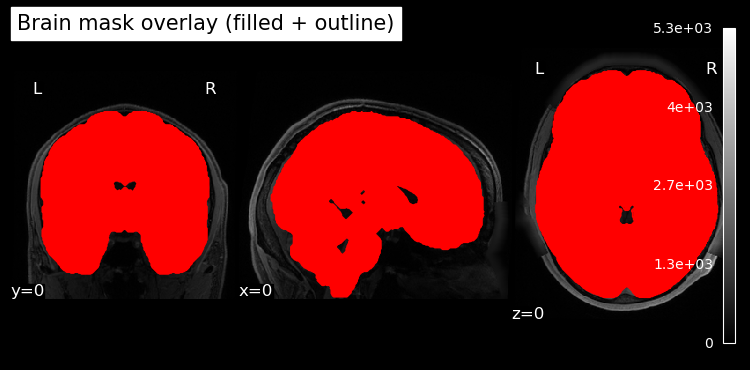

In [29]:
# Create a base anatomical plot
display = plotting.plot_anat(
    t1_img,
    title="Brain mask overlay (filled + outline)",
    display_mode='ortho',
    cut_coords=(0, 0, 0),
    draw_cross=False
)

# Add the filled red/orange mask
display.add_overlay(
    t1_mask,
    cmap='autumn',   # warm colors (orange/red)
    alpha=0.5
)

# Add a clear red outline around the mask
display.add_contours(
    t1_mask,
    levels=[0.5],
    colors='red',
    linewidths=1.5
)

### 2d) Skull Stripping

In [34]:
# --- Apply anatomical mask manually (lab version, adapted) ---
base = Path("/Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410")
anat_dir = base / "T1w"
mask_path = base / "derivatives" / "anat" / "T1w_brainmask.nii.gz"     # <- mask we created earlier
img_path  = anat_dir / "T1w.nii.gz"                                   # <- original T1
out_path  = base / "derivatives" / "anat" / "T1w_brain_labmasked.nii.gz"
out_path.parent.mkdir(parents=True, exist_ok=True)

# Load data
img = nib.load(str(img_path))
mask = nib.load(str(mask_path))
img_data = img.get_fdata()
mask_data = mask.get_fdata()

# Apply mask (zero out everything outside the brain)
masked_data = img_data * (mask_data > 0)

# Save the skull-stripped result
masked_img = nib.Nifti1Image(masked_data, img.affine, img.header)
nib.save(masked_img, str(out_path))
print(f"Saved skull-stripped T1 to: {out_path}")

Saved skull-stripped T1 to: /Users/pamelavandenenden/Desktop/NSSP fMRI Labs/subject101410/derivatives/anat/T1w_brain_labmasked.nii.gz


### 2e) Normalization (align t1 to mni152)

## 3) Functional preprocessing 

### 3a) firstfew volumes removal

### 3b) silce timing

### 3c) motion correction

### 3d) coregistration (register fmri to t1)

### 3e) spatial smoothing

## 4) Design matrix 

## 5) First-level GLM & maps

## 6) Example contrast 

## 7) PCA